In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from dpa import attacker
from matplotlib.patches import Polygon
from tensorflow_privacy.privacy.analysis.rdp_accountant \
    import compute_rdp, get_privacy_spent

adversary = attacker.GaussianAttacker()

/Users/d052098/opt/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (4.0.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
from scipy.stats import norm

rho = 0.99
eps = np.log(rho/(1-rho))
print(eps)
#eps = 4.6
delt = 0.001

print(2*norm.cdf(eps/(2*np.sqrt(2*np.log(1.25/delt))))-1)

4.595119850134589
0.45706897038216643


In [3]:
def load_pickle(directory, filename):
    with np.load(os.path.join(directory, filename), allow_pickle=True) as data:
        return data['run_0'].item()
    
def load_results(experiment_path, rho, dlt):
    results = []
    for dirpath, dirnames, filenames in os.walk(experiment_path):
        for filename in [f for f in filenames if f"rho_{rho}_delta_{dlt}_local" in f]:    
            results.append(load_pickle(dirpath, filename))
    return results
def load_results_all(experiment_path):
    results = []
    for dirpath, dirnames, filenames in os.walk(experiment_path):
        for filename in filenames:#[f for f in filenames if f"rho_{rho}_delta_{dlt}_local" in f]:    
            results.append(load_pickle(dirpath, filename))
    return results

In [4]:
mnist_dict = {}
DLT = 0.01
RHO = 0.9
single_evaluate = ["rho_90_local_unbound", "rho_90_global_unbound", "rho_90_global", "rho_90_local","rho_75_local", "rho_75_global", "rho_99_local", "rho_99_global", "rho_52_local", 'rho_52_global']
    
for directory in single_evaluate:
    results = load_results_all('../experiments/mnist/ssim/'+directory)
    
    print(directory)
    
    runs = len(results)
    print(runs)
    mnist_dict[f'sensitivities_{directory}'] = [result['sensitivites'] for result in results]
    mnist_dict[f'max_biased_beliefs_mnist_{directory}'] = [result['biased_beliefs'][0][-1] for result in results]
    mnist_dict[f'train_acc_mnist_{directory}'] = [result['train_acc'][-1] for result in results]
    mnist_dict[f'acc_{directory}'] = [result['test_acc'][-1] for result in results]

    success_rate_empir = sum(bias_belief > 0.5 for bias_belief in mnist_dict[f'max_biased_beliefs_mnist_{directory}'])
    print('count ', success_rate_empir)
    mnist_dict[f'advantage_mnist_{directory}'] = success_rate_empir/runs-(1-success_rate_empir/runs)
    print("advantage ", mnist_dict[f'advantage_mnist_{directory}'])
    excess_portion = sum(bias_belief > np.round(RHO,2) for bias_belief in mnist_dict[f'max_biased_beliefs_mnist_{directory}'])
    print(f"Portion of experiments with biased beliefs larger than rho:{excess_portion/runs}")

rho_90_local_unbound
999
count  613
advantage  0.22722722722722732
Portion of experiments with biased beliefs larger than rho:0.002002002002002002
rho_90_global_unbound
998
count  635
advantage  0.27254509018036077
Portion of experiments with biased beliefs larger than rho:0.004008016032064128
rho_90_global
999
count  588
advantage  0.17717717717717707
Portion of experiments with biased beliefs larger than rho:0.0
rho_90_local
993
count  616
advantage  0.24068479355488415
Portion of experiments with biased beliefs larger than rho:0.002014098690835851
rho_75_local
245
count  141
advantage  0.15102040816326534
Portion of experiments with biased beliefs larger than rho:0.0
rho_75_global
492
count  252
advantage  0.024390243902439046
Portion of experiments with biased beliefs larger than rho:0.0
rho_99_local
493
count  374
advantage  0.5172413793103448
Portion of experiments with biased beliefs larger than rho:0.10547667342799188
rho_99_global
246
count  161
advantage  0.3089430894308942
P

In [5]:
single_evaluate = ['rho_52_global']

for directory in single_evaluate:
    results = load_results_all('../experiments/mnist/ssim/'+directory)
    
    print(directory)
    
    runs = len(results)
    print(runs)
    mnist_dict[f'sensitivities_{directory}'] = [result['sensitivites'] for result in results]
    mnist_dict[f'max_biased_beliefs_mnist_{directory}'] = [result['biased_beliefs'][0][-1] for result in results]
    mnist_dict[f'train_acc_mnist_{directory}'] = [result['train_acc'][-1] for result in results]
    mnist_dict[f'acc_{directory}'] = [result['test_acc'][-1] for result in results]

    success_rate_empir = sum(bias_belief > 0.5 for bias_belief in mnist_dict[f'max_biased_beliefs_mnist_{directory}'])
    print('count ', success_rate_empir)
    mnist_dict[f'advantage_mnist_{directory}'] = success_rate_empir/runs-(1-success_rate_empir/runs)
    print("advantage ", mnist_dict[f'advantage_mnist_{directory}'])
    excess_portion = sum(bias_belief > np.round(RHO,2) for bias_belief in mnist_dict[f'max_biased_beliefs_mnist_{directory}'])
    print(f"Portion of experiments with biased beliefs larger than rho:{excess_portion/runs}")

rho_52_global
243
count  122
advantage  0.004115226337448652
Portion of experiments with biased beliefs larger than rho:0.0


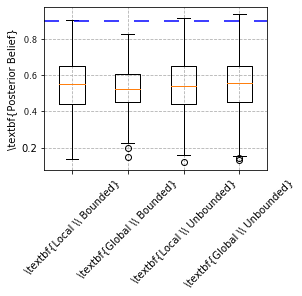

In [6]:
data_to_plot = []
beliefs_eval = ["rho_90_local", "rho_90_global", "rho_90_local_unbound", "rho_90_global_unbound"]

for directory in beliefs_eval:
    data_to_plot.append(mnist_dict[f'max_biased_beliefs_mnist_{directory}'])


fig = plt.figure(1, figsize=(4, 3))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(data_to_plot)
ax.grid(ls="dashed")
plt.xticks(rotation=45)
plt.rc('text', usetex=True)
ax.set_xticklabels([r'\textbf{Local \\ Bounded}', r'\textbf{Global \\ Bounded}', r'\textbf{Local \\ Unbounded}', r'\textbf{Global \\ Unbounded}'])
ax.axhline(y=0.9, ls="dashed", color="blue", dashes=(10, 10))
ax.set_ylabel(r"\textbf{Posterior Belief}")
plt.savefig("belief_boxplot.pdf", bbox_inches='tight')
plt.show()

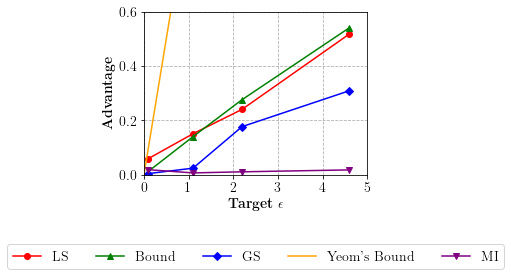

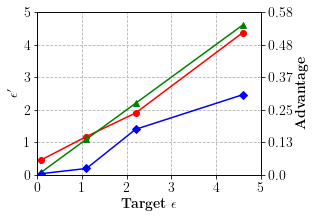

In [7]:
#avg_local = np.amax(max_biased_beliefs_bounded_local)
#avg_global = np.amax(max_biased_beliefs_bounded_global)

#local_vals = np.array([advantage_local_rho_52, advantage_local_rho_75, advantage_local_rho_90, advantage_local_rho_99])
#global_vals = np.array([advantage_global_rho_52, advantage_global_rho_75, advantage_global_rho_90, advantage_global_rho_99])

# plt.style.use("fast")
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rcParams.update({'font.size': 14})


adv_local_mnist = []
adv_global_mnist = []
posterior_evaluate = ["rho_52_local", 'rho_52_global', "rho_75_local", "rho_75_global", "rho_90_local", "rho_90_global", "rho_99_local", "rho_99_global"]

for directory in posterior_evaluate:
    if f"local" in directory:
        adv_local_mnist.append(mnist_dict[f'advantage_mnist_{directory}'])
    else:
        adv_global_mnist.append(mnist_dict[f'advantage_mnist_{directory}'])

rhos = [0.52, .75, .9, .99]
delt=0.01
epsilons = [np.log(rho/(1-rho)) for rho in rhos]

#eps_cont = np.arange(0, 1, 0.01)
adv_cont = [2*norm.cdf(eps/(2*np.sqrt(2*np.log(1.25/delt))))-1 for eps in epsilons]

#print(adv_cont)
#print(local_vals)
#print(global_vals)

fig, ax = plt.subplots(1, figsize=(4,3))

# ax2 = ax.twinx()
#ax.callbacks.connect("ylim_changed", convert_ax_c_to_celsius)
ax.set_ylim(-0.0,0.6)
one =ax.plot(epsilons, np.array(adv_local_mnist), 'ro', color='red', label='LS',marker='o', linestyle='-')
ax.grid(ls="dashed")
#ax2.set_yscale('log')
ax.axis([0, 4, -0.0, 0.6])
two = ax.plot(epsilons, adv_cont, 'ro', color='green', label='Bound',marker='^', linestyle='-')
ax.plot(epsilons, np.array(adv_global_mnist), 'ro', color='blue', label='GS',marker='D', linestyle='-')
#ax.axhline(y=3, ls="dashed", color="orange", dashes=(10, 10), label=r'$C$ Unbounded')
ax.grid(ls="dashed")


epsilons_yeom_bound = [0,1,2,3,4,5]
advantage_yeom = np.minimum(1,np.exp(epsilons_yeom_bound)-1)
ax.plot(epsilons_yeom_bound, np.array(advantage_yeom), 'ro', color='orange', label='Yeom\'s Bound',marker='', linestyle='-')

adult_advantages = [0.019000000000000006, 0.007000000000000001, 0.011, 0.01799999999999998]
# mi_empirical_eps = [2*np.around(norm.ppf((adv+1)/2)*np.sqrt(2*np.log(1.25/delt)), 2) for adv in np.array(adult_advantages)]
ax.plot(epsilons, adult_advantages, 'ro', color='purple', label=r'MI',marker='v', linestyle='-')


ax.set(xlabel=r"\textbf{Target $\epsilon$}", ylabel=(r'\textbf{Advantage}'))
#listcomprehension
# ax2.set_yticks(range(0,4))
ticks_rhos = [2*np.around(norm.ppf((adv+1)/2)*np.sqrt(2*np.log(1.25/delt)), 2) for adv in [0, 0.2,0.4,0.6]]
# ax2.set_yticklabels(ticks_rhos)
ax.set_xticks(range(0,6))
ax.set_xticks(range(0,6))
legend = ax.legend(loc=10, ncol=5, bbox_to_anchor=(0.5, -0.5))



# ax2.set_ylabel('Factual epsilon')
#ax2.tick_params('y')
#ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax2.plot(epsilons, epsilons,'x',markersize=20, label = 'test')

plt.savefig("MI_comparison_mnist.pdf", bbox_inches='tight')
#plt.savefig("unbounded_sensitivity.pdf", bbox_inches='tight')
plt.show()

def export_legend(legend, filename="legend.pdf"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.show()

# import pylab
# fig = pylab.figure()
# figlegend = pylab.figure(figsize=(3,2))
# ax = fig.add_subplot(111)
# lines = ax.plot(range(10), pylab.randn(10), range(10), pylab.randn(10))
# figlegend.legend(one, ('one'), 'center')
# fig.show()
# figlegend.show()
# figlegend.savefig('legend.png')
#------------------------------------------------------
yeom_bound = []
for epsilon in epsilons:
    yeom_bound.append(np.exp(epsilon)-1)


empirical_eps_local = [2*np.around(norm.ppf((adv+1)/2)*np.sqrt(2*np.log(1.25/delt)), 2) for adv in np.array(adv_local_mnist)]
empirical_eps_global = [2*np.around(norm.ppf((adv+1)/2)*np.sqrt(2*np.log(1.25/delt)), 2) for adv in np.array(adv_global_mnist)]

fig, ax = plt.subplots(1, figsize=(4,3))
ax.plot(epsilons, empirical_eps_local, 'ro', color='red', label=r'LS',marker='o', linestyle='-')
ax.grid(ls="dashed")
ax.axis([0, 4, 0, 5])
ax.plot(epsilons, epsilons, 'ro', color='green', label='Bound', marker='^', linestyle='-')
ax.plot(epsilons, empirical_eps_global, 'ro', color='blue', label=r'GS',marker='D', linestyle='-')
#ax.axhline(y=3, ls="dashed", color="orange", dashes=(10, 10), label=r'$C$ Unbounded')
ax.grid(ls="dashed")


advs = [np.around(2*norm.cdf(eps/(2*np.sqrt(2*np.log(1.25/delt))))-1, 2) for eps in [0,1,2,3,4,5]]
yeom_bound2 = np.log(np.array(advs)+1)
# ax.plot([0,1,2,3,4,5], yeom_bound2, 'ro', color='orange', label=r'Yeom Bound',marker='', linestyle='-')
 
mnist_advantages = [0.019000000000000006, 0.007000000000000001, 0.011, 0.01799999999999998]
mi_empirical_eps = [2*np.around(norm.ppf((adv+1)/2)*np.sqrt(2*np.log(1.25/delt)), 2) for adv in np.array(mnist_advantages)]
# ax.plot(epsilons, mi_empirical_eps, 'ro', color='purple', label=r'MI',marker='v', linestyle='-')


ax.set(xlabel=r"\textbf{Target $\epsilon$}", ylabel=r"$\epsilon'$")
ax.set_xticks(range(0,6))
# plt.legend(loc=10, ncol=2, bbox_to_anchor=(0.5, -0.5))

ax2 = ax.twinx()
ax2.set_yticks(range(0,6))
ticks_rhos = advs
ax2.set_yticklabels(ticks_rhos)
ax2.set_ylabel(r'\textbf{Advantage}')



plt.savefig("factual_eps_from_adv.pdf", bbox_inches='tight')
#plt.savefig("unbounded_sensitivity.pdf", bbox_inches='tight')
plt.show()


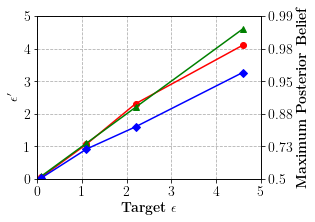

In [8]:
#avg_local = np.amax(purchase_dict[f'max_biased_beliefs_purch_{directory}'])
#avg_global = np.amax(max_biased_beliefs_bounded_global)
max_beliefs_local = []
max_beliefs_global = []
posterior_evaluate = ["rho_52_local", 'rho_52_global', "rho_75_local", "rho_75_global", "rho_90_local", "rho_90_global", "rho_99_local", "rho_99_global"]

for directory in posterior_evaluate:
    if f"local" in directory:
        max_beliefs_local.append(np.amax(mnist_dict[f'max_biased_beliefs_mnist_{directory}']))
    else:
        max_beliefs_global.append(np.amax(mnist_dict[f'max_biased_beliefs_mnist_{directory}']))

empirical_eps_local = [np.log(rho/(1-rho)) for rho in max_beliefs_local]
empirical_eps_global = [np.log(rho/(1-rho)) for rho in max_beliefs_global]

fig, ax = plt.subplots(1, figsize=(4,3))
ax.plot(epsilons, empirical_eps_local, 'ro', color='red', label=r'LS',marker='o', linestyle='-')
ax.grid(ls="dashed")
ax.axis([0, 4, 0, 5])
ax.plot(epsilons, epsilons, 'ro', color='green', label='Bound', marker='^', linestyle='-')
ax.plot(epsilons, empirical_eps_global, 'ro', color='blue', label=r'GS',marker='D', linestyle='-')
#ax.axhline(y=3, ls="dashed", color="orange", dashes=(10, 10), label=r'$C$ Unbounded')
ax.grid(ls="dashed")

ax.set(xlabel=r"\textbf{Target $\epsilon$}", ylabel=r"$\epsilon'$")
ax.set_xticks(range(0,6))
# plt.legend(loc=10, ncol=2, bbox_to_anchor=(0.5, -0.5))

rhos = [np.around(1/(1+np.exp(-1*ep)),2) for ep in [0.01,1,2,3,4,5]]
ax2 = ax.twinx()
ax2.set_yticks(range(0,6))
ticks_rhos = rhos
ax2.set_yticklabels(ticks_rhos)
ax2.set_ylabel(r'\textbf{Maximum Posterior Belief}')

plt.savefig("factual_eps_from_belief.pdf", bbox_inches='tight')
#plt.savefig("unbounded_sensitivity.pdf", bbox_inches='tight')
plt.show()


In [9]:
def compute_heterogenous_rdp(sampling_probabilities, noise_multipliers,
                             steps_list, orders):
    rdp = 0
    for q, noise_multiplier, steps in zip(sampling_probabilities, noise_multipliers, steps_list):
        rdp += compute_rdp(q, noise_multiplier, steps, orders)

    return rdp

def compute_rdp_eps_and_order(noise_multipliers, epochs, delta):
        orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
        #print(orders)
        sampling_probability = 1.0
        rdp = compute_heterogenous_rdp(sampling_probability*np.ones(epochs),
                          noise_multipliers=noise_multipliers,
                          steps_list= np.ones(epochs),
                          orders=orders)

        rdp_eps, _, order = get_privacy_spent(orders, rdp, target_delta=delta)
        return rdp_eps, order

0.08004270767353656
<function Attacker.get_noise_multiplier_for_rdp_eps.<locals>.f at 0x7fcc813b4560>
0.07734532096628097
1.0986122886681098
<function Attacker.get_noise_multiplier_for_rdp_eps.<locals>.f at 0x7fccd299a050>
0.43767502596763797
2.1972245773362196
<function Attacker.get_noise_multiplier_for_rdp_eps.<locals>.f at 0x7fcc813b4710>
1.0068575602259935
4.595119850134589
<function Attacker.get_noise_multiplier_for_rdp_eps.<locals>.f at 0x7fcc813b4050>
2.122371061517597


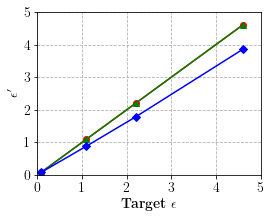

In [10]:
composed_delta=0.01
rhos = [0.52, 0.75, 0.9, 0.99]

epochs = 30
clipping_norm = 6
#alpha = 7.8#17
rdp_eps = []
factual_eps = []
mean_eps = []


to_evaluate = ["rho_52_local", "rho_75_local", "rho_99_local",  "rho_90_local"]
    


for directory, rho in zip(to_evaluate, rhos):
    composed_eps = np.log(rho/(1-rho))
    print(composed_eps)
    original_mult = adversary.get_noise_multiplier_for_rdp_eps(composed_eps, composed_delta, epochs)
    mults = original_mult*np.ones(epochs)
    for sensitivities in mnist_dict[f'sensitivities_{directory}']:
        noise_mult = np.array([original_mult*clipping_norm/local for local in sensitivities])

        epsilon, order = compute_rdp_eps_and_order(noise_mult, epochs, composed_delta)
        factual_eps.append(epsilon)
    mean_eps.append(np.max(factual_eps))
    print(np.mean(factual_eps))

fig, ax = plt.subplots(1, figsize=(4,3))
ax.plot(epsilons, epsilons, 'ro', color='red', label=r'LS',marker='o', linestyle='-')
ax.grid(ls="dashed")
ax.axis([0, 4, 0, 5])
ax.plot(epsilons, epsilons, 'ro', color='green', label='Bound', marker='^', linestyle='-')
ax.plot(epsilons, mean_eps, 'ro', color='blue', label=r'GS',marker='D', linestyle='-')

#ax.axhline(y=3, ls="dashed", color="orange", dashes=(10, 10), label=r'$C$ Unbounded')
ax.grid(ls="dashed")

ax.set(xlabel=r"\textbf{Target $\epsilon$}", ylabel=r"$\epsilon'$")
ax.set_xticks(range(0,6))
# plt.legend(loc=10, ncol=2, bbox_to_anchor=(0.5, -0.5))

plt.savefig("factual_eps_sensitivities_max.pdf", bbox_inches='tight')
#plt.savefig("unbounded_sensitivity.pdf", bbox_inches='tight')
plt.show()

In [11]:
DLT = 0.01
RHO = 0.9

results = []
results = load_results("../experiments/mnist/ssim/mins_and_max_difference/max_1", RHO, DLT)
sensitivities_max_1 = [result['sensitivites'] for result in results]

results = []
results = load_results("../experiments/mnist/ssim/mins_and_max_difference/max_2", RHO, DLT)
sensitivities_max_2 = [result['sensitivites'] for result in results]

results = []
results = load_results("../experiments/mnist/ssim/mins_and_max_difference/max_3", RHO, DLT)
sensitivities_max_3 = [result['sensitivites'] for result in results]
runs = len(results)
print(runs)

results = []
results = load_results("../experiments/mnist/ssim/mins_and_max_difference/median", RHO, DLT)
sensitivities_median = [result['sensitivites'] for result in results]
runs = len(results)
print(runs)

results = []
results = load_results("../experiments/mnist/ssim/mins_and_max_difference/min_1", RHO, DLT)
sensitivities_min_1 = [result['sensitivites'] for result in results]
runs = len(sensitivities_min_1)
print(runs)

results = []
results = load_results("../experiments/mnist/ssim/mins_and_max_difference/min_2", RHO, DLT)
sensitivities_min_2 = [result['sensitivites'] for result in results]
runs = len(sensitivities_min_2)
print(runs)

results = []
results = load_results("../experiments/mnist/ssim/mins_and_max_difference/min_3", RHO, DLT)
sensitivities_min_3 = [result['sensitivites'] for result in results]

244
239
244
250


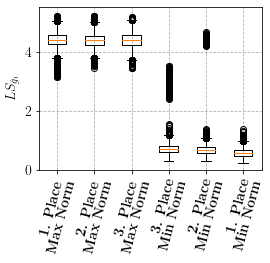

In [12]:
plt.style.use("fast")
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rcParams.update({'font.size': 14})

data_to_plot = [np.array(sensitivities_max_1).flatten(), np.array(sensitivities_max_2).flatten(), np.array(sensitivities_max_3).flatten(), np.array(sensitivities_min_3).flatten(), np.array(sensitivities_min_2).flatten(), np.array(sensitivities_min_1).flatten()]
fig = plt.figure(1, figsize=(4, 3))
# Create an axes instance
ax = fig.add_subplot(111)
ax.set_ylim(0,5.5)
# Create the boxplot
bp = ax.boxplot(data_to_plot)
plt.xticks(rotation=75)
ax.grid(ls="dashed")
ax.set_xticklabels([r'\textbf{1. Place \\Max Norm}', r'\textbf{2. Place \\Max Norm}',r'\textbf{3. Place \\Max Norm}', r'\textbf{3. Place \\Min Norm}', r'\textbf{2. Place \\Min Norm}', r'\textbf{1. Place \\Min Norm}'])
ax.set_ylabel(r"$LS_{\hat{g}_i}$")
plt.savefig("min_max_distance_sensitivity.pdf", bbox_inches='tight')
plt.show()

[0.8362, 0.8537, 0.8428, 0.8422, 0.8589]


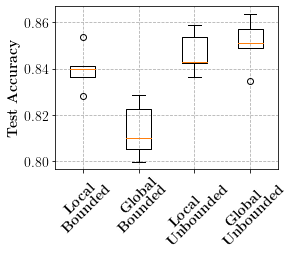

In [13]:
DLT = 0.01
RHO = 0.9

results = load_results("../experiments/mnist/ssim/large_batch/bounded_global", RHO, DLT)
acc_bounded_global = [result['test_acc'][-1] for result in results]
results = load_results("../experiments/mnist/ssim/large_batch/bounded_local", RHO, DLT)
acc_bounded_local = [result['test_acc'][-1] for result in results]
results = load_results("../experiments/mnist/ssim/large_batch/unbounded_global", RHO, DLT)
acc_unbounded_global = [result['test_acc'][-1] for result in results]
results = load_results("../experiments/mnist/ssim/large_batch/unbounded_local", RHO, DLT)
acc_unbounded_local = [result['test_acc'][-1] for result in results]


acc_unbounded_local.append(0.8422)
acc_unbounded_local.append(0.8589)
print(acc_unbounded_local)
acc_unbounded_global.append(0.8637)
acc_unbounded_global.append(0.8488)

plt.style.use("fast")
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rcParams.update({'font.size': 14})


data_to_plot = [acc_bounded_local, acc_bounded_global, acc_unbounded_local,  acc_unbounded_global]
fig = plt.figure(1, figsize=(4, 3))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(data_to_plot)

ax.grid(ls="dashed")
plt.xticks(rotation=45)
ax.set_xticklabels([r'\textbf{Local \\ Bounded}', r'\textbf{Global \\ Bounded}', r'\textbf{Local \\ Unbounded}', r'\textbf{Global \\ Unbounded}'])

ax.set_ylabel(r"\textbf{Test Accuracy}")
plt.savefig("accuracy_boxplot.pdf", bbox_inches='tight')
plt.show()

[ 2.5474288  2.5553758  2.5737028 ... 12.958038  13.062523  13.909537 ]
[ 2.5474288  2.5553758  2.5737028 ... 12.958038  13.062523  13.909537 ]
29970


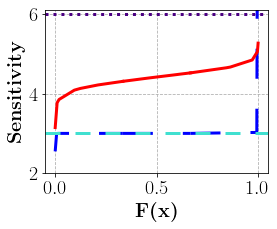

In [14]:
plt.style.use("fast")
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rcParams.update({'font.size': 20})

#X  = np.arange(0,1, 0.000033534540576794097920858484)
X  = np.arange(0,1, 1.0/len(np.array(mnist_dict['sensitivities_rho_90_local_unbound']).flatten()))#0.00003333333333333333333333333)
CY = np.sort(np.array(mnist_dict['sensitivities_rho_90_local_unbound']).flatten())
print(CY)
#CY /= CY[-1]
print(CY)
print(len(CY))
#data_to_plot = [np.array(sensitivities_bounded_local).flatten(), np.array(sensitivities_unbounded_local).flatten()]
fig = plt.figure(1, figsize=(4, 3))
# Create an axes instance
ax = fig.add_subplot(111)
ax.set_ylim(2,6.1)
# Create the boxplot
#bp = ax.boxplot(data_to_plot)
bp = ax.plot(X, CY,linewidth=3, color="blue", ls="dashed",dashes=(10, 10), label=r'$LS_g(D)$, U')

X  = np.arange(0,1, 1.0/len(np.array(mnist_dict['sensitivities_rho_90_local']).flatten()))#0.000033534540576794097920858484)
CY = np.sort(np.array(mnist_dict['sensitivities_rho_90_local']).flatten())
#CY /= CY[-1]
data_to_plot = [np.array(mnist_dict['sensitivities_rho_90_local']).flatten(), np.array(mnist_dict['sensitivities_rho_90_local_unbound']).flatten()]
# Create an axes instance
#ax.set_ylim(2,6.1)
# Create the boxplot
#bp = ax.boxplot(data_to_plot)
bp2 = ax.plot(X, CY, linewidth=3,color="red", label=r'$LS_g(D)$, B')

ax.grid(ls="dashed")
#ax.set_xticklabels([r'Local Bounded', r'Local Unbounded'])
ax.axhline(y=3, ls="dashdot", linewidth=3,color="turquoise",dashes=(5, 5),  label=r'$C$ , U')
ax.axhline(y=6, ls="dotted",linewidth=3, color="indigo",  label=r'$2C$, B')
ax.set_ylabel(r"\textbf{Sensitivity}")
ax.set_xlabel(r"\textbf{F(x)}")
# legend = plt.legend(loc=10, ncol=4, bbox_to_anchor=(0.5, -0.7))
plt.savefig("local_sensitivity.pdf", bbox_inches='tight')
plt.show()


export_legend(legend, "sensitivity_legend.pdf")

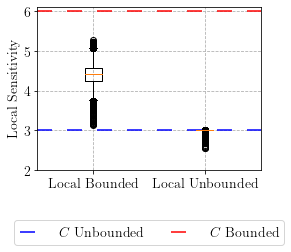

In [15]:
plt.style.use("fast")
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
matplotlib.rcParams.update({'font.size': 14})

unbounded_local_sens = [np.minimum(3,sens) for sens in np.array(mnist_dict['sensitivities_rho_90_local_unbound']).flatten()]

data_to_plot = [np.array(mnist_dict['sensitivities_rho_90_local']).flatten(), unbounded_local_sens]
fig = plt.figure(1, figsize=(4, 3))
# Create an axes instance
ax = fig.add_subplot(111)
ax.set_ylim(2,6.1)
# Create the boxplot
bp = ax.boxplot(data_to_plot)
ax.grid(ls="dashed")
ax.set_xticklabels([r'Local Bounded', r'Local Unbounded'])
ax.axhline(y=3, ls="dashed", color="blue", dashes=(10, 10), label=r'$C$ Unbounded')
ax.axhline(y=6, ls="dashed", color="red", dashes=(10, 10), label=r'$C$ Bounded')
ax.set_ylabel(r"Local Sensitivity")
plt.legend(loc=8, ncol=2, bbox_to_anchor=(0.5, -0.5))
plt.savefig("local_sensitivity.pdf", bbox_inches='tight')
plt.show()

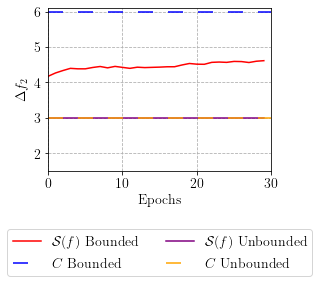

In [16]:
DLT = 0.01
RHO = 0.9
epochs = 30
sensitivities_bounded = mnist_dict['sensitivities_rho_90_local'][2]#results[2]['sensitivites']
sensitivities_unbounded = mnist_dict['sensitivities_rho_90_local_unbound'][2]#results[4]['sensitivites']

fig, ax = plt.subplots(1, figsize=(4,3))


ax.plot(range(0,30), sensitivities_bounded, 'ro', color='red', label=r'$\mathcal{S}(f)$ Bounded',marker='', linestyle='-')
ax.axhline(y=6, ls="dashed",  color='blue', dashes=(10, 10), label=r'$C$ Bounded')
ax.grid(ls="dashed")

ax.axis([0, epochs, 1.5, 6.1])
#ax1.ylabel("sensitivity")
#ax1.xlabel("number of mechanism executions")
ax.set(xlabel='Epochs (Bounded DP)', ylabel='Clipping Norm')


#_, axes = plt.subplots(1,1,figsize=(4,3))
ax.plot(range(0,30), sensitivities_unbounded, 'ro', color='purple', label=r'$\mathcal{S}(f)$ Unbounded',marker='', linestyle='-')
ax.axhline(y=3, ls="dashed", color="orange", dashes=(10, 10), label=r'$C$ Unbounded')
ax.grid(ls="dashed")
ax.axis([0, 30, 1.5, 6.1])
#ax2.ylabel(r"sensitivity")
#ax2.xlabel(r"number of mechanism executions")
ax.set(xlabel='Epochs', ylabel=r'$\Delta f_2$')

plt.legend(loc=10, ncol=2, bbox_to_anchor=(0.5, -0.5))

plt.savefig("local_sensitivity.pdf", bbox_inches='tight')
#plt.savefig("unbounded_sensitivity.pdf", bbox_inches='tight')
plt.show()

In [17]:
def plot_hist(rho, delt, key):
    max_biased_beliefs_unbounded_local = mnist_dict[key]#[result['biased_beliefs'][0][-1] for result in results]
    runs = len(max_biased_beliefs_unbounded_local)


    plt.style.use("fast")
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    matplotlib.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(1,1,figsize=(4,3))

    colors = plt.cm.RdBu(np.linspace(0.0,0.9,20))

    cm = plt.cm.get_cmap('RdYlBu_r')

    # Plot histogram.
    n, bins, patches = axes.hist(max_biased_beliefs_unbounded_local,bins=25,edgecolor='black')
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # scale values to interval [0,1]
    col = bin_centers - np.min(bin_centers)
    col /= np.max(col)

    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))

    axes.set_xlabel(r"$\beta(\cdot)$ over {} runs".format(runs))
    axes.set_ylabel(r"Output of DP-Adam")
    plt.axis([0, 1, 0, 200])
    #plt.legend( loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=3, facecolor="white")
    axes.set_axisbelow(True)
    axes.grid(ls="dashed")
    plt.savefig(f"ml_attack_biased_belief_distributions_local_unbounded_rho{RHO}.pdf", bbox_inches='tight')
    plt.show()

    excess_portion = sum(bias_belief > np.round(rho,2) for bias_belief in max_biased_beliefs_unbounded_local)
    success_rate_empir = sum(bias_belief > 0.5 for bias_belief in max_biased_beliefs_unbounded_local)

    epochs=30
    epsilon = adversary.get_epsilon_for_confidence_bound(rho)
    success_rate = adversary.expected_rdp_success_rate(adversary.get_noise_multiplier_for_rdp_eps(epsilon, delt, epochs), epochs)
    print("delta: ", delt)
    print(f"Portion of experiments with biased beliefs larger than rho:{excess_portion/runs}")
    print("membership adv ", success_rate-(1-success_rate))
    print(f"Portion of experiments with biased beliefs larger than 0.5:{success_rate_empir/runs-(1-success_rate_empir/runs)}")

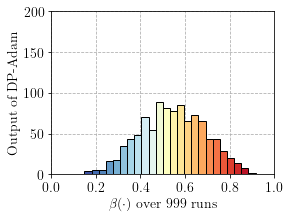

<function Attacker.get_noise_multiplier_for_rdp_eps.<locals>.f at 0x7fccd2b37680>
changed
delta:  0.01
Portion of experiments with biased beliefs larger than rho:0.002002002002002002
membership adv  0.2561767421042713
Portion of experiments with biased beliefs larger than 0.5:0.22722722722722732


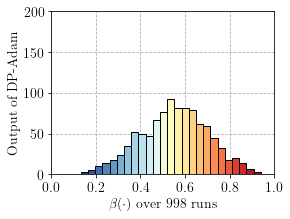

<function Attacker.get_noise_multiplier_for_rdp_eps.<locals>.f at 0x7fccb15a60e0>
changed
delta:  0.01
Portion of experiments with biased beliefs larger than rho:0.004008016032064128
membership adv  0.2561767421042713
Portion of experiments with biased beliefs larger than 0.5:0.27254509018036077


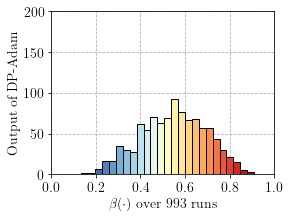

<function Attacker.get_noise_multiplier_for_rdp_eps.<locals>.f at 0x7fccd2b275f0>
changed
delta:  0.01
Portion of experiments with biased beliefs larger than rho:0.002014098690835851
membership adv  0.2561767421042713
Portion of experiments with biased beliefs larger than 0.5:0.24068479355488415


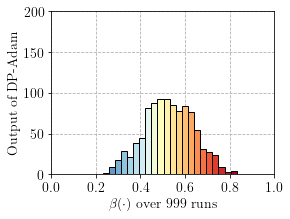

<function Attacker.get_noise_multiplier_for_rdp_eps.<locals>.f at 0x7fccd29dd050>
changed
delta:  0.01
Portion of experiments with biased beliefs larger than rho:0.0
membership adv  0.2561767421042713
Portion of experiments with biased beliefs larger than 0.5:0.17717717717717707


In [18]:
plot_hist(0.9,0.01, f'max_biased_beliefs_mnist_rho_90_local_unbound')
plot_hist(0.9,0.01, f'max_biased_beliefs_mnist_rho_90_global_unbound')
plot_hist(0.9,0.01, f'max_biased_beliefs_mnist_rho_90_local')
plot_hist(0.9,0.01, f'max_biased_beliefs_mnist_rho_90_global')